In [67]:
import json
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import constants 
####################
# Choose a context #
####################
# context = xo.ContextCpu()
# context = xo.ContextCpu(omp_num_threads='auto')
# buf = context.new_buffer()

# # Ion properties:
# m_u = 931.49410242e6 # eV/c^2 -- atomic mass unit
# A = 207.98 # Lead-208
# Z = 82  # Number of protons in the ion (Lead)
# Ne = 3 # Number of remaining electrons (Lithium-like)
# q0=Z-Ne
# m_e = 0.511e6 # eV/c^2 -- electron mass
# m_p = 938.272088e6 # eV/c^2 -- proton mass
# clight = 299792458.0 # m/s



# m_ion = A*m_u + Ne*m_e # eV/c^2
# equiv_proton_momentum = 236e9 # eV/c = gamma_p*m_p*v
# gamma_p = np.sqrt( 1 + (equiv_proton_momentum/m_p)**2 ) # equvalent gamma for protons in the ring

# p0c = equiv_proton_momentum*(q0) # eV/c
# gamma = np.sqrt( 1 + (p0c/m_ion)**2 ) # ion relativistic factor
# beta = np.sqrt(1-1/(gamma*gamma)) # ion beta


In [68]:

mass0=37.21*1e9 #eV/c**2
energy_mean=7.65*1e12 #eV
gamma=energy_mean/mass0
beta = np.sqrt(1-1/(gamma*gamma)) # ion beta

clight = 299792458.0 # m/s

p0c=gamma*mass0*beta #eV/c

A=40
Z=20
q0=17

mc = A*0.931e9 # eV/c useful for ions

gamma2 = np.sqrt( 1 + (p0c/mass0)**2 ) # ion relativistic factor verify

In [69]:
print('gamma',gamma)
print('gamma2',gamma2)

gamma 205.5898951894652
gamma2 205.5898951894652


In [70]:
#%%
##################
# Build TrackJob #
##################

fname_sequence ='/home/pkruyt/cernbox/xsuite-env/xtrack/test_data/sps_w_spacecharge/line_no_spacecharge_and_particle.json'

with open(fname_sequence, 'r') as fid:
     input_data = json.load(fid)
SPS_line = xt.Line.from_dict(input_data['line'])

# SPS_line=xt.Line.from_json('SPS_2021_Pb_nominal.json')



# SPS_tracker = xt.Tracker(_context=context, _buffer=buf, line=sequence)

# Build a reference particle
particle_sample = xp.Particles(mass0=mass0, q0=q0, p0c=p0c)
SPS_line.particle_ref = particle_sample
twiss = SPS_line.twiss(symplectify=True)

twiss_dict=dict(twiss)

#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]

qs=twiss['qs']
bets=twiss['betz0']


#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101

Dx  =  2.444732 # m
Dpx =  0.097522

Dy  =  0.0 # m
Dpy =  0.0

#index of gamma factory along SPS line: 16675

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        
        dx=Dx,
        dpx=Dpx,
        dy=Dy,
        dpy=Dpy,
        # qs=qs,
        # bets=bets,
        )

arc2 = xt.LineSegmentMap(
        dx=0,
        dpx=0,
        dy=0,
        dpy=0,
        # qs=qs,
        # bets=bets,
        )

# #sequence based on the LinearTransferMatrix element:
# M = xt.LinearTransferMatrix(_buffer=buf, _context=context,
#             Q_s=0.0131,
#             beta_s=sigma_z/sigma_dp)

T_per_turn = circumference/(clight*beta)

Loading line from dict:   0%|          | 0/14704 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [71]:
nemitt = 1.5e-6 # m*rad (normalized emittance)
emitt=nemitt*beta*gamma

np.sqrt(beta_x*emitt)

0.12977692602658136

In [72]:
Np=int(1e6)
n_part = int(1e4)

u  = np.random.normal(scale=np.sqrt(emitt), size=Np)
up = np.random.normal(scale=np.sqrt(emitt)/beta_x, size=Np)

x  = u*np.sqrt(beta_x) # m
px = up*np.sqrt(beta_x) - u*alpha_x/np.sqrt(beta_x) # rad

u  = np.random.normal(scale=np.sqrt(emitt), size=Np)
up = np.random.normal(scale=np.sqrt(emitt)/beta_y, size=Np)

y  = u*np.sqrt(beta_y) # m
py = up*np.sqrt(beta_y) - u*alpha_y/np.sqrt(beta_y) # rad



In [73]:
sigma_x = 0.80e-3 # m
sigma_y = 0.57e-3  # m
sigma_dp = 2e-4 # relative ion momentum spread

nemitt = 1.5e-6 # m*rad (normalized emittance)
sigma_z = 10*1e-2 # m

emittance=nemitt/(beta*gamma)

sigma_px=np.std(px)
sigma_py=np.std(py)

particles0 = xp.Particles(
     mass0 = mass0, # eV/c^2
     q0    = q0,
     p0c   = p0c, # eV
     x     = np.random.normal(scale=sigma_x, size=n_part),
     px    = np.random.normal(scale=sigma_px, size=n_part),
     y     = np.random.normal(scale=sigma_y, size=n_part),
     py    = np.random.normal(scale=sigma_py, size=n_part),
     zeta  = np.random.normal(scale=sigma_z, size=n_part),
     delta = np.random.normal(scale=sigma_dp, size=n_part)
        )


In [74]:
np.std(particles0.delta)

LinkedArrayCpu(0.00020134)

In [75]:
# particles0.x=0
# particles0.px=0
# particles0.y=0
# particles0.py=0

std_x= np.std(particles0.x)
std_px= np.std(particles0.px)
std_y= np.std(particles0.y)
std_py= np.std(particles0.py)
std_zeta= np.std(particles0.zeta)
std_delta= np.std(particles0.delta)

print(sigma_px*1e3)
print(std_px*1e3)
print(sigma_py*1e3)
print(std_py*1e3)

4.360737876564217
4.330926172525099
4.361747473087151
4.3223411379042105


In [76]:
##################
# Laser Cooler #
##################

#laser-ion beam collision angle
theta_l = 1.3*np.pi/180 # rad
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
hw0 = 661.89 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

ion_excited_lifetime=0.4279*1e-12
lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

# Shift laser wavelength for fast longitudinal cooling:5
# lambda_l = lambda_l*(1+1*sigma_dp) # m

laser_frequency = clight/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
# sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 3.0e-3 #m
laser_energy = 2e-3

GF_IP = xt.PulsedLaser(
                laser_x=1.4*1e-3,
                laser_y=0,
                laser_z=0,
                
                laser_direction_nx = 0,
                laser_direction_ny = ny,
                laser_direction_nz = nz,
                laser_energy         = laser_energy, # J
                laser_duration_sigma = sigma_t, # sec
                laser_wavelength = lambda_l, # m
                laser_waist_radius = laser_waist_radius, # m
                laser_waist_shift = 0, # m
                ion_excitation_energy = hw0, # eV
                ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                )

# simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
max_time_s = 5
int_time_s = 0.1
T_per_turn = circumference/(clight*beta)
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)

# num_turns = int(1e5)
# save_interval = num_turns/100
#save_interval=1

# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                              n_repetitions=int(num_turns/save_interval),
                              repetition_period=save_interval,
                              num_particles=n_part)

# create a monitor object, to reduce holded data
monitor2 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                              n_repetitions=int(num_turns/save_interval),
                              repetition_period=save_interval,
                              num_particles=n_part)
   
# line = xt.Line(
#         elements=[monitor,arc,GF_IP])

line = xt.Line(
        elements=[monitor,arc])

# line = xt.Line(
#         elements=[monitor,arc,GF_IP,arc2])

line.particle_ref = xp.Particles(mass0=mass0, q0=q0, p0c=p0c)

#context = xo.ContextCpu()
#context = xo.ContextCpu(omp_num_threads='auto')
context = xo.ContextCpu(omp_num_threads=3)

line.build_tracker(_context=context)


Laser pulse duration sigma_t = 2.04 ps
Laser wavelength = 770.11 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [77]:
transverse_kick=hw0/p0c
longitudinal_energy_loss_max = hw0*2*gamma
longitudinal_kick = longitudinal_energy_loss_max/p0c
longitudinal_kick

3.5576341304393075e-08

In [78]:
particles=particles0.copy()

line.track(particles, num_turns=num_turns,
              turn_by_turn_monitor=False,with_progress=True)

# extract relevant values
x = monitor.x[:,:,0]
px = monitor.px[:,:,0]
y = monitor.y[:,:,0]
py = monitor.py[:,:,0]
delta = monitor.delta[:,:,0]
zeta = monitor.zeta[:,:,0]
state = monitor.state[:,:,0]
time = monitor.at_turn[:, 0, 0] * T_per_turn




# compute actions. for x, remove the dp/p contribution:
action_x = (x-Dx*delta)**2/beta_x + beta_x*(px-Dpx*delta)**2
# for y, simple compute:
action_y = y**2/beta_y + beta_y*py**2

emitt_RMS = np.sqrt(np.mean(x*x)*np.mean(xp*xp) - np.mean(x*xp)*np.mean(x*xp))

np.savez('results/Pulsed_data.npz', x=x, px=px, y=y, py=py, zeta=zeta, delta=delta,
         action_x=action_x,action_y=action_y, state=state, time=time,s_per_turn=T_per_turn)

Tracking:   0%|          | 0/216900 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


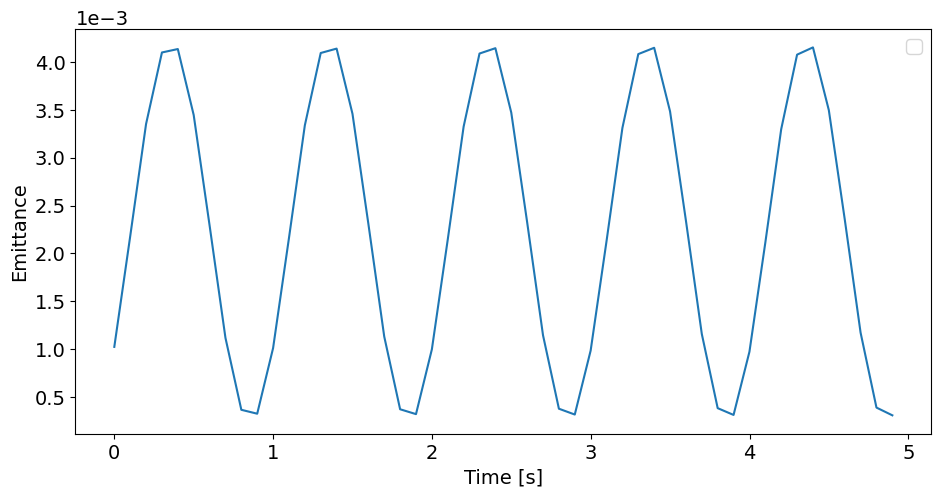

In [79]:
emittance=np.mean(action_x,axis=1)


plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 14})  # set the default fontsize to 14
plt.plot(time, emittance)
# plt.plot(time, np.mean(action_x, axis=1), label=f'RMS $\epsilon_x$')
# plt.plot(time, np.mean(action_y, axis=1), label=f'RMS $\epsilon_y$')
plt.xlabel('Time [s]')
plt.ylabel('Emittance')
plt.legend()
plt.tight_layout()
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

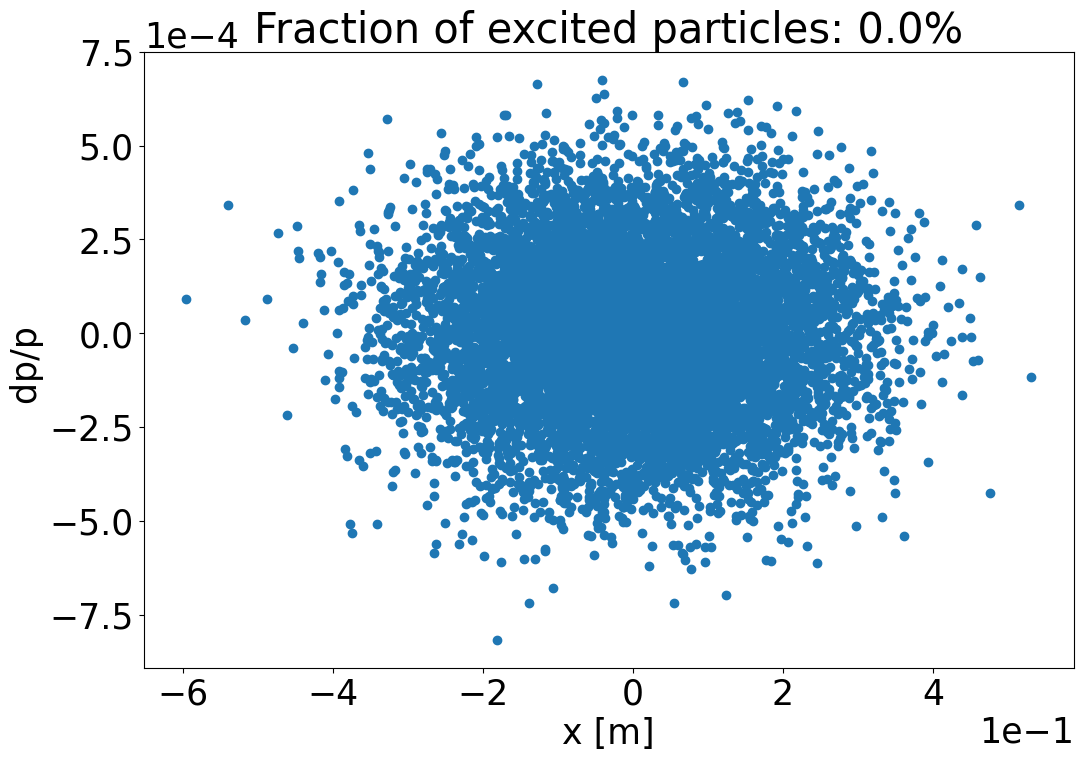

In [80]:
excited=particles.state==2

fraction_excitation = sum(excited)/len(excited)

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.delta)
plt.scatter(particles.x[excited],particles.delta[excited])
plt.xlabel('x [m]')
plt.ylabel('dp/p ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

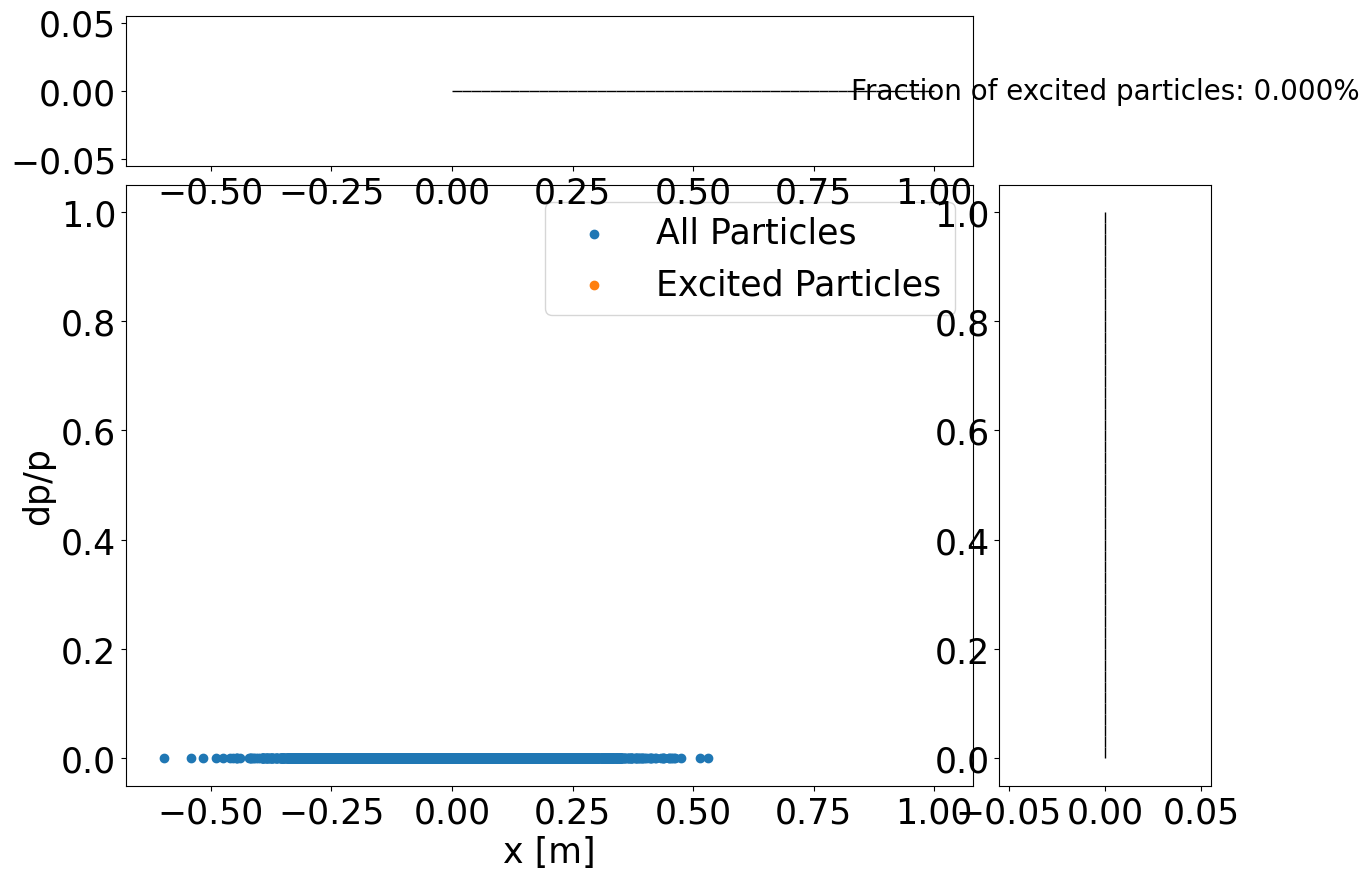

In [81]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Assuming you have particles and excited defined somewhere in your code
# excited = particles.state == 2
# fraction_excitation = sum(excited) / len(excited)

# Create a 2x2 grid layout
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

# Scatter plot
ax_main = fig.add_subplot(gs[1, 0])
ax_main.scatter(particles.x, particles.delta, label='All Particles')
ax_main.scatter(particles.x[excited], particles.delta[excited], label='Excited Particles')
ax_main.set_xlabel('x [m]')
ax_main.set_ylabel('dp/p')
ax_main.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_main.legend()

# Histogram on the right
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
#ax_right.hist(particles.delta, bins=50, orientation='horizontal', color='lightblue', edgecolor='black')
ax_right.hist(particles.delta[excited], bins=50, orientation='horizontal', color='orange', edgecolor='black')

# Histogram on the top
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
#ax_top.hist(particles.x, bins=50, color='lightblue', edgecolor='black')
ax_top.hist(particles.x[excited], bins=50, color='orange', edgecolor='black')

# Title with the fraction of excited particles
title_ax = fig.add_subplot(gs[0, 1])
title_ax.set_axis_off()
title_ax.text(0.5, 0.5, f'Fraction of excited particles: {fraction_excitation * 100:.3f}%', ha='center', va='center', fontsize=20)

plt.show()


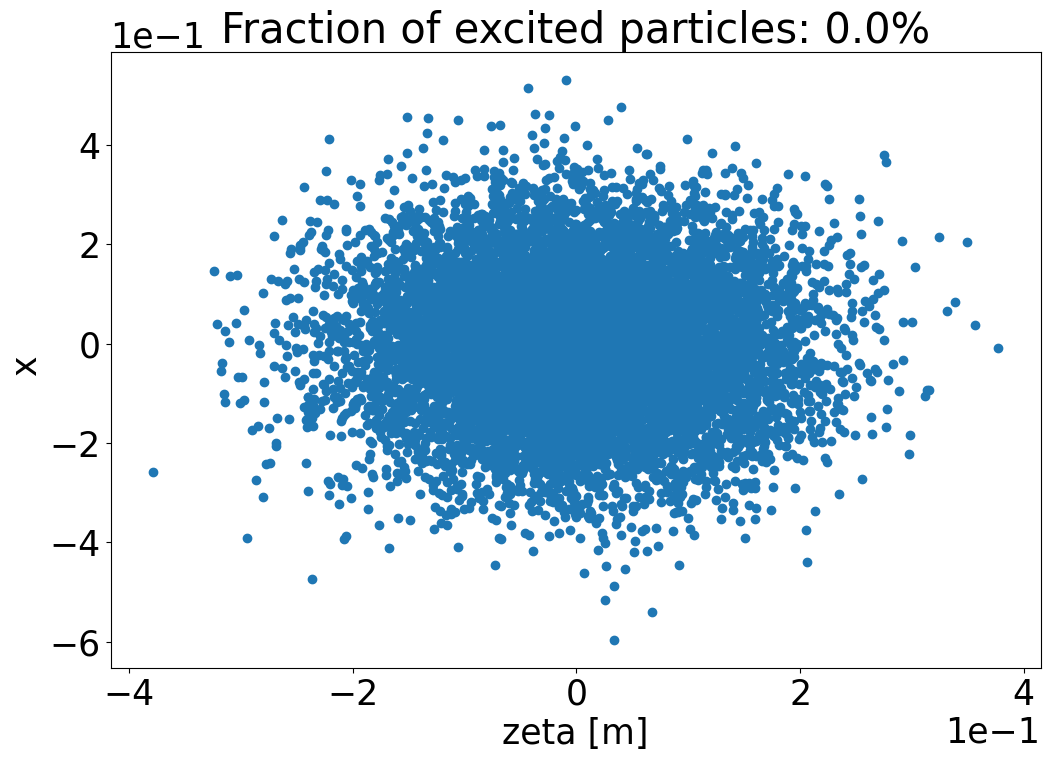

In [82]:
excited=particles.state==2

fraction_excitation = sum(excited)/len(excited)

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.zeta,particles.x)
plt.scatter(particles.zeta[excited],particles.x[excited])
plt.xlabel('zeta [m]')
plt.ylabel('x ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

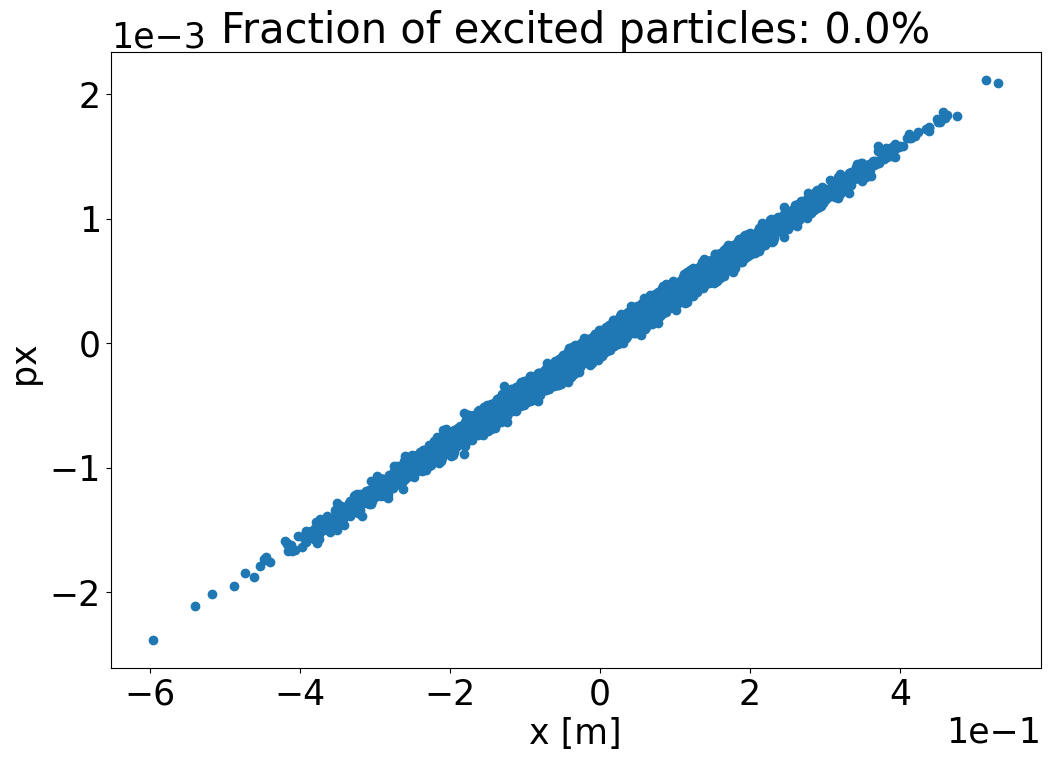

In [83]:
excited=particles.state==2

fraction_excitation = sum(excited)/len(excited)

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.px)
plt.scatter(particles.x[excited],particles.px[excited])
plt.xlabel('x [m]')
plt.ylabel('px ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()